In [1]:
# -*- coding: utf-8 -*-
import numpy as np
from numpy import exp,pi,sqrt,cos,sin,log10,abs
from numpy.fft import *
from scipy.interpolate import RegularGridInterpolator as interpolate
import time
import matplotlib.pyplot as plt
#from transform import *
from matplotlib.patches import Circle
from  matplotlib.transforms import Affine2D
from numpy.linalg import det

plt.style.use('dark_background')   

In [2]:
def Kick2d(cf,kx,ky,verbose=False):
    """Calculates a Gaussian random field from the squareroot of the 
       Fourier components of the correlation functions (cf) and returns
       the field and its first and second derivatives in x an y direction.
       The derivatives are calculated using the kx and ky arguements, which are the 
       wave vecotors.
       
       Returns: U,Fx,Fy
    """   
    phase=(2*np.random.rand(*cf.shape)-1)*pi
    nx=cf.shape[0]
    ny=cf.shape[1]
   
    
    for i in range(0,nx//2):
        for j in range(0,ny):
            phase[(nx-i)%nx ,(ny-j)%ny]=-phase[i,j]
    
    
    phase[0,0]=0
    phase[nx//2,0]=0
    phase[0,ny//2]=0
    phase[nx//2,ny//2]=0
    
    
    cf*=exp(1.j*phase)
    cf[0,0]=0
    
    N=sqrt(nx*ny)
    u=N*ifft2(cf)
    Fx=N*ifft2(1j*kx*cf)
    Fy=N*ifft2(1j*ky*cf)
    Fxx=-N*ifft2(kx*kx*cf)
    Fyy=-N*ifft2(ky*ky*cf)
    Fxy=-N*ifft2(kx*ky*cf)
    
    u=np.real(u)
    
    
    if verbose:    
        s=np.std(u)
        print('Max. Im.',np.max(np.abs(np.imag(u))))
        print('mean',np.mean(u))
        print('std',s)
        
    
    return u,np.real(Fx),np.real(Fy),np.real(Fxx),np.real(Fyy),np.real(Fxy)

In [3]:
def grid(Nx,Ny,Lx=1,Ly=1,x0=0,y0=0):
    return np.meshgrid((np.arange(Nx)/(1.0*Nx)-0.5)*Lx+x0,(np.arange(Ny)/(1.0*Ny)-0.5)*Ly+y0,indexing='ij')

In [4]:
def gauss(x,y,lc):
    return exp(-(x*x+y*y)/lc**2) 

In [5]:
def gaussani(x,y,lc,a=1,b=1,p=0):
    Mx=(a*cos(p))**2+(b*sin(p))**2
    My=(a*sin(p))**2+(b*cos(p))**2
    Mxy=2*(a**2-b**2)*sin(p)*cos(p)
   
    return exp(-(Mx*x*x+My*y*y+Mxy*x*y)/lc**2)  

In [6]:
def ShowSource(ind,pxv,pyv,Mn,d):
    """
        This is just a function to plot the linear images of a circular source
    """
    px=pxv[ind]*pscale
    py=pyv[ind]*pscale
    xx=x[ind]
    yy=y[ind]
    M=Mn[ind,:,:]
    
    tr0=pscale*np.array([[M[2,0],M[2,1],0],[M[3,0],M[3,1],0],[0,0,1/pscale]])
    l=abs(det([[M[2,0],M[2,1]],[M[3,0],M[3,1]]])*d)
    cc=(np.minimum(np.maximum(log10(1/l),bright_cutoff[0]),bright_cutoff[1])-bright_cutoff[0])/(bright_cutoff[1]-bright_cutoff[0])
    
    
    tr=Affine2D().translate(-0.5-px,-0.5-py)+Affine2D(tr0)+Affine2D().translate(0.5+px,0.5+py)
    cnew=Circle((0.5+px, 0.5+py),rim,facecolor=(1,1,1,cc),transform=tr+ax3.transAxes)
    ax3.add_patch(cnew)
    ax2.scatter(xx,yy,s=8,facecolor=(0.5,0.5,1))

Kick No. 1

done

computation time: 8.23358 s
calculating histogram time: 0.301472 s
Pscale: 34.822662076732115


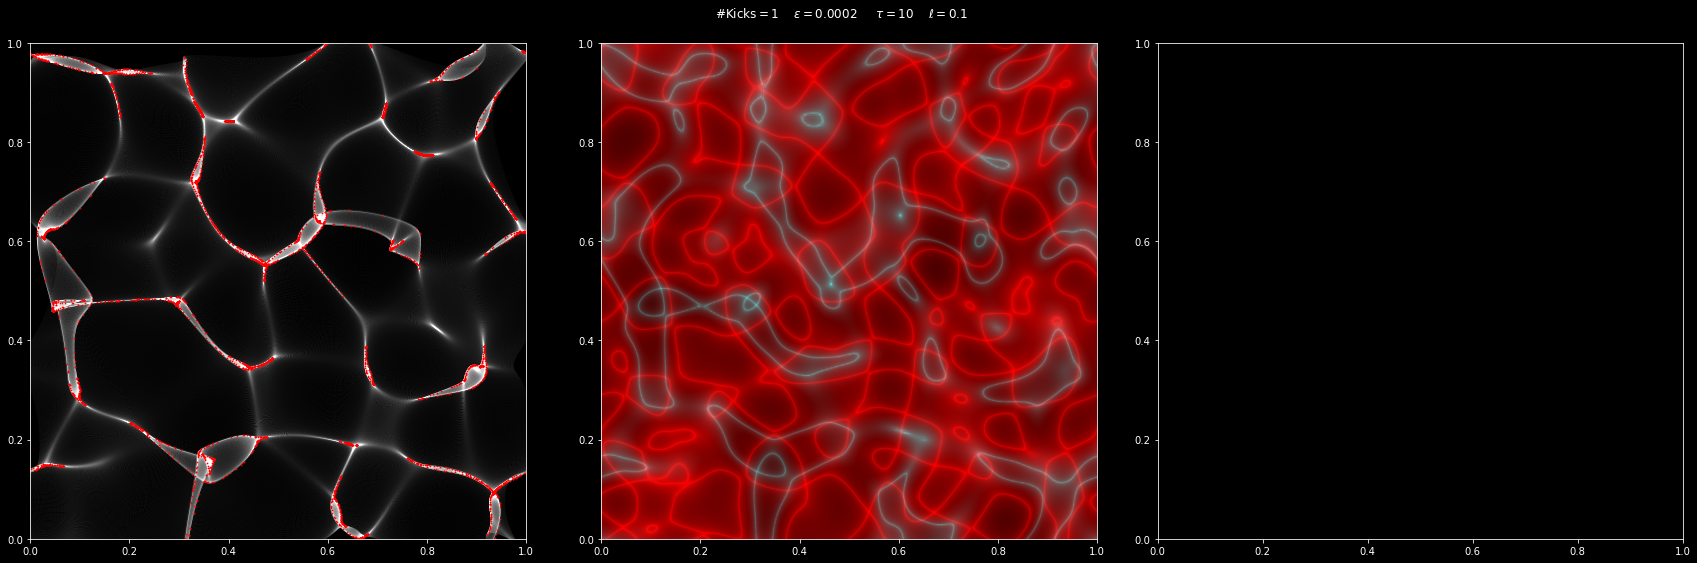

In [8]:
if __name__ == '__main__':
        
    Ng=1000  # Number of gridpoints for random potential  
    NK=1     #Number of Kicks
    eps=2e-4  # Kick strength
    tau=10 # time between kicks
    ell=0.1 #Correlation length should not be larger than approx 0.1
    
    caccu=1e-3   #accuracy in caustic detection
    
    Nim=500   #Resolution of the density image 
    Nin=2000  #Number of initial conditions = Nin x Nin
    rim=0.05


    # setting up the correlation function
    
    xg,yg=grid(Ng,Ng) # this is a grid ranging from -0.5 to 0.5 in both directions
    #c=gaussani(xg,yg,0.1,b=2)
    
    c=gauss(xg,yg,ell) # correlation function
    
    
    #k-vector for the Fourier transform
    k=np.roll(np.arange(-Ng/2+1,Ng/2+1,dtype="double"),-Ng//2+1)*2*np.pi
    one=np.ones(Ng)
    kx=np.outer(k,one)
    ky=np.outer(one,k)

    xg+=0.5 # this is just to save some shifts later
    yg+=0.5 
    f=fft2(ifftshift(c))
    cf=eps*complex(1,0)*sqrt(f)  # Fourier trans. of the correlation
     
        
    # setting up initial conditions 
    # and defining all variables needed.
    x,y=grid(Nin,Nin,x0=0.5,y0=0.5)
    x=x.flatten()
    y=y.flatten()
    r=np.zeros((Nin*Nin,2)) # The interploation routine likes this
    r[:,0]=x
    r[:,1]=y
    px=np.zeros(Nin*Nin)
    py=np.zeros(Nin*Nin)
    Fx=np.zeros((Ng+1,Ng+1)) #Force
    Fy=np.zeros((Ng+1,Ng+1))
    Fxx=np.zeros((Ng+1,Ng+1)) #spatial derivatives of the force
    Fyy=np.zeros((Ng+1,Ng+1))
    Fxy=np.zeros((Ng+1,Ng+1))
      
    M=np.zeros((Nin*Nin,4,4)) # Stability Matrix
    Mn=np.zeros((Nin*Nin,4,4))# time step of M
    for i in range(Nin*Nin):
          M[i,:,:]=np.identity(4)
          
    xi=np.append(xg[:,0],[1])
    yi=np.append(yg[0,:],[1])
    
    start_time = time.time()
    
    K0=np.matrix(np.identity(4))
      
      
    # Time evolution:
        
    for t in range(NK):
        print("Kick No. %d\n"%(t+1))
        #calculating the kick
        U,Fx[0:-1,0:-1],Fy[0:-1,0:-1],Fxx[0:-1,0:-1],Fyy[0:-1,0:-1],Fxy[0:-1,0:-1]=Kick2d(cf,kx,ky)
         
        #Make the interpolation in periodic boundary conditions
        # The intepolations routine does not do periodic B.C. by itself
        Fx[-1,:]=Fx[0,:] 
        Fy[-1,:]=Fy[0,:]
        Fx[:,-1]=Fx[:,0]
        Fy[:,-1]=Fy[:,0]
        Fx[-1,-1]=Fx[0,0]
        Fy[-1,-1]=Fy[0,0]
        Fxx[-1,:]=Fxx[0,:]  
        Fxx[:,-1]=Fxx[:,0]
        Fxx[-1,-1]=Fxx[0,0]
        Fyy[-1,:]=Fyy[0,:]  
        Fyy[:,-1]=Fyy[:,0]
        Fyy[-1,-1]=Fyy[0,0]
        Fxy[-1,:]=Fxy[0,:]  
        Fxy[:,-1]=Fxy[:,0]
        Fxy[-1,-1]=Fxy[0,0]
       
        print("done\n")    
        Kx=interpolate((xi,yi),Fx)
        Ky=interpolate((xi,yi),Fy)
        Vxx=interpolate((xi,yi),Fxx)
        Vxy=interpolate((xi,yi),Fxy)
        Vyy=interpolate((xi,yi),Fyy)
        rmod=r-np.floor(r)
         
        #Momentum equation of motion (kick)
        px+=Kx(rmod)
        py+=Ky(rmod)
        
        V00=Vxx(rmod)
        V01=Vxy(rmod)
        V11=Vyy(rmod)
        for j in range(4):
            #time evolution of the stability matrix
            Mn[:,0,j]=(1+tau*V00)*M[:,0,j]+tau*V01*M[:,1,j]+tau*M[:,2,j]
            Mn[:,1,j]=tau*V01*M[:,0,j]+(1+tau*V11)*M[:,1,j]+tau*M[:,3,j]
            Mn[:,2,j]=+V00*M[:,0,j]+V01*M[:,1,j]+M[:,2,j]
            Mn[:,3,j]=+V01*M[:,0,j]+V11*M[:,1,j]+M[:,3,j]
         
        #position equation of motion (drift)    
        r[:,0]+=px*tau
        r[:,1]+=py*tau

        M=Mn.copy()
         
    stop_time=time.time()      
    print('computation time: %g s'%(stop_time-start_time))

    

    #calculating the density and plotting it in the left panel
    
    dens,xedges,yedges=np.histogram2d(r[:,0],r[:,1],bins=int(Nim),range=[[0,1],[0,1]])
    dens/=float(np.max(dens))
    
    print('calculating histogram time: %g s'%(time.time()-stop_time))
    s=np.std(dens)
    m=np.mean(dens)
    cutoff=1./50
    vmax=np.maximum(cutoff,5*s)
    fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(24,8),facecolor="k")
    
    ax1.imshow(dens.transpose(),cmap="Greys_r",vmax=vmax,extent=[0,1,0,1],origin='lower')
    
    fig.suptitle(r"#Kicks$=%d$    $\epsilon=%g$     $\tau=%g$    $\ell=%g$"%(NK,eps,tau,ell))
    
    
    #calculate subdeterminants of the stability matrix
    
    d=det(M[:,0:2,0:2])
    dp=det(M[:,2:4,0:2])
    
    
    #highlight trajectories that (almost) touch a caustic
    cind=np.argwhere(np.abs(d)<caccu) # find points near caustics
    ax1.scatter(r[cind,0],r[cind,1],marker='.',s=2,color=(1,0,0,1))
    ax1.set_xlim([0,1])
    ax1.set_ylim([0,1])
    
    
    #plotting the inverse "magnifactions" in the central panel
    bright_scale=[np.min(log10(1/abs(dp))),np.max(log10(1/abs(dp)))]
    bright_cutoff=[-2,5]
    dim=d.reshape(Nin,Nin,order='F').transpose()
    dim=np.maximum(np.minimum(0.2*log10(1/np.abs(d.reshape(Nin,Nin,order='F'))+1e-5),1),0)
    img=np.zeros([Nin,Nin,3])
    img[:,:,1]=dim
    img[:,:,2]=dim
    dim=np.maximum(np.minimum(0.2*(log10(1/np.abs(dp.reshape(Nin,Nin,order='F'))+1e-5)),1),0)
    img[:,:,0]=dim
    
    #ax2.imshow(log10(1./np.abs(dim)),cmap="Blues_r",extent=[0,1,0,1],origin='lower',vmax=5)    
    ax2.imshow(img,extent=[0,1,0,1],origin='lower')
    plt.tight_layout(pad=1.5)
    
    
    #Chose scale used to blow up the "sky view" in the right panel
    pscale=1/(3*np.max([np.max(np.abs(px)),np.max(np.abs(py))]))
    
    print("Pscale:",pscale)
   #  ax2=plt.gca()
    
    #this  is just to make the plot interactive
    def onclick(event):
        
        if event.inaxes==ax1:
            ind=np.argwhere(sqrt((r[:,0]-event.xdata)**2+ (r[:,1]-event.ydata)**2)<=2./Nin)
           
            if len(ind)>0:
                print(np.amax(dens[floor(r[ind,0]*Nim).astype(int),floor(r[ind,1]*Nim).astype(int)])/m)
            else:
                print('none')
            ax2.clear()
            ax2.imshow(img,extent=[0,1,0,1],origin='lower')
            #ax2.imshow(log10(1./np.abs(dim)),cmap="Blues_r",extent=[0,1,0,1],origin='lower',vmax=5) 
            ax2.scatter(x[ind],y[ind],s=8,facecolor=(0.9,0.9,0))
           
        elif event.inaxes==ax2:
            ix=int(event.xdata*Nin)
            iy=int(event.ydata*Nin)
            ind=iy+ix*Nin
            ShowSource(ind,px,py,Mn,d[ind])
        elif event.inaxes==ax3:
            ax3.clear()
            ax2.clear()
            #ax2.imshow(log10(1./np.abs(dim)),cmap="Blues_r",extent=[0,1,0,1],origin='lower',vmax=5)
            ax2.imshow(img,extent=[0,1,0,1],origin='lower')
           
           
        fig.canvas.draw()
       
    cid = fig.canvas.mpl_connect('button_press_event', onclick)
    
    plt.show()     